In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score,calinski_harabasz_score
from sklearn_extra.cluster import KMedoids

from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Uninstall and reinstall with correct NumPy version
!pip uninstall -y numpy scikit-learn-extra
!pip install "numpy<2.0" --no-deps

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 128.5 MB/s eta 0:00:00


In [ ]:
!pip install scikit-learn-extra --no-deps

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 12.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.3.0-cp312-cp312-linux_x86_64.whl size=1963614 sha256=43d6a8a34dbad69e63d255be29c6c74e023dd978448e8955c01f78f790c807d3
  Stored in directory: /root/.cache/pip/wheels/17/4d/c3/c6d5d563c1bf8146d059d63be3678abc2f2801fba0aaf5f0b8
Successfully built scikit-learn-extra


In [ ]:
import numpy as np
print(f"NumPy version: {np.__version__}")

from sklearn_extra.cluster import KMedoids
print(" KMedoids imported successfully!")

NumPy version: 1.26.4
 KMedoids imported successfully!


In [ ]:
# ============================================================================
#  LOAD YOUR FEATURE ENGINEERED DATA
# ============================================================================
from google.colab import drive
import os

drive.mount('/content/drive')

customer_df = pd.read_parquet('/content/drive/My Drive/Colab Notebooks/DSC678-Capstone/Banking_Project/project_dataset/final_features.parquet')
customer_df_info=customer_df.info()
customer_df.head()

print(f"\n Data Loaded successfully!")


Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
Index: 136372 entries, 0 to 136371
Data columns (total 48 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   customer_id                 136372 non-null  int64         
 1   residence_country           136372 non-null  object        
 2   gender                      136372 non-null  int64         
 3   age                         136372 non-null  int64         
 4   first_join_date             136372 non-null  datetime64[ns]
 5   residence_index             136372 non-null  object        
 6   channel_entrance            136372 non-null  object        
 7   activity_status             136372 non-null  int64         
 8   household_gross_income      136372 non-null  float64       
 9   saving_account              136372 non-null  int64         
 10  guarantees                  136372 non-null  int64         
 11  junior_account    

In [ ]:
# ============================================================================
# CALCULATE RECENCY AND PREPARE RFM FEATURES
# ============================================================================

'''
Calculate recency:
Lower recency= more recently active = better
-Recent joiners with activity= low recency (good)
-Old customers without recent activity= high recency (bad)
'''

#For customers with transactions use tenure as proxy
# In production calculate days since last transaction
customer_df['recency_proxy']=customer_df['customer_tenure_months']

#Filter to customers with adoption history
print(f"\n Filtering customers")
print(f" Before:{len(customer_df):,} total customer")

active_customers=customer_df[customer_df['total_adoptions']>0].copy()

print(f" After:{len(active_customers):,} customers with adoption history")
print(f" Filtered out:{len(customer_df)} - {len(active_customers):,} customers with no adoption")


 Filtering customers
 Before:136,372 total customer
 After:104,898 customers with adoption history
 Filtered out:136372 - 104,898 customers with no adoption


In [ ]:
#Create a RFM dataframe
rfm_df= active_customers[['customer_id','recency_proxy','total_adoptions','portfolio_value']].copy()
rfm_df.columns=['customer_id','recency','frequency','monetary']

#Handle any remaining nan values
rfm_df=rfm_df.fillna(rfm_df.median())

print(rfm_df[['recency','frequency','monetary']].describe())

             recency      frequency       monetary
count  104898.000000  104898.000000  104898.000000
mean      189.872682       4.064787    8533.404167
std        30.697547       3.534880   22225.597085
min         0.000000       1.000000       0.000000
25%       174.233333       1.000000     388.005000
50%       185.866667       3.000000     872.035000
75%       208.633333       6.000000    8728.975000
max       260.100000      29.000000  235311.290000


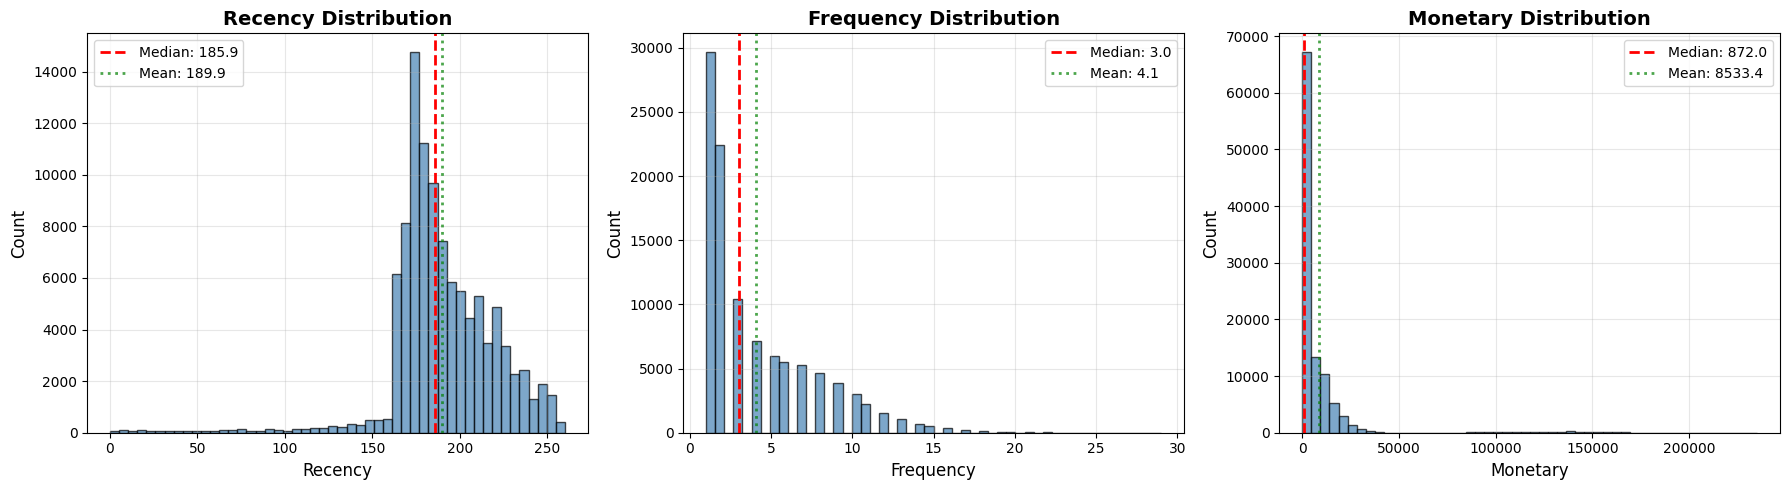

In [ ]:
# ============================================================================
#  VISUALIZE RFM DISTRIBUTIONS
# ============================================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, col in enumerate(['recency', 'frequency', 'monetary']):
    mean_val = rfm_df[col].mean()
    median_val = rfm_df[col].median()

    axes[idx].hist(rfm_df[col], bins=50, color='steelblue',
                   edgecolor='black', alpha=0.7)

    # Plot BOTH - let stakeholders see the difference
    axes[idx].axvline(median_val, color='red', linestyle='--',
                     label=f'Median: {median_val:.1f}', linewidth=2)
    axes[idx].axvline(mean_val, color='green', linestyle=':',
                     label=f'Mean: {mean_val:.1f}', linewidth=2, alpha=0.7)

    axes[idx].set_xlabel(f'{col.title()}', fontsize=12)
    axes[idx].set_ylabel('Count', fontsize=12)
    axes[idx].set_title(f'{col.title()} Distribution',
                       fontsize=14, fontweight='bold')
    axes[idx].legend(fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# ============================================================================
# STANDARDIZE RFM FEATURES
# ============================================================================

#Extract RFM features
X_rfm=rfm_df[['recency','frequency','monetary']].values

print(f"\nBefore standardization:")
print(f"   Recency range: [{X_rfm[:, 0].min():.1f}, {X_rfm[:, 0].max():.1f}]")
print(f"   Frequency range: [{X_rfm[:, 1].min():.1f}, {X_rfm[:, 1].max():.1f}]")
print(f"   Monetary range: [€{X_rfm[:, 2].min():.1f}, €{X_rfm[:, 2].max():.1f}]")

#Standardize (mean=0, std=1)
scaler=StandardScaler()
X_rfm_scaled=scaler.fit_transform(X_rfm)

print(f"Features standardized")
print(f"Mean: {X_rfm_scaled.mean(axis=0)}")
print(f"Standard Deviation: {X_rfm_scaled.std(axis=0)}")




Before standardization:
   Recency range: [0.0, 260.1]
   Frequency range: [1.0, 29.0]
   Monetary range: [€0.0, €235311.3]
Features standardized
Mean: [ 4.16173289e-16 -1.51729845e-17  5.52730150e-17]
Standard Deviation: [1. 1. 1.]


In [ ]:
print(f"\n K-Medoids Clustering with Sampling")
print(f"   Original dataset: {len(X_rfm_scaled):,} customers")

# Sample 30% of data for clustering
sample_size = int(len(X_rfm_scaled) * 0.3)
np.random.seed(42)
sample_indices = np.random.choice(len(X_rfm_scaled), size=sample_size, replace=False)
X_sample = X_rfm_scaled[sample_indices]

print(f"   Using sample: {len(X_sample):,} customers (30%)")
print(f"   Distance metric: Euclidean")
print(f"   Number of clusters: 5")

# Fit K-Medoids on sample
kmedoids = KMedoids(
    n_clusters=5,
    metric='euclidean',
    method='alternate',
    init='k-medoids++',
    max_iter=100,
    random_state=42
)

print(f"\n Fitting K-Medoids on sample...")
sample_labels = kmedoids.fit_predict(X_sample)
centers = kmedoids.cluster_centers_

# Now assign ALL customers to nearest medoid
print(f"Assigning all {len(X_rfm_scaled):,} customers to clusters...")
from scipy.spatial.distance import cdist
distances = cdist(X_rfm_scaled, centers, metric='euclidean')
labels = distances.argmin(axis=1)

# Get medoid indices in full dataset
medoid_indices = kmedoids.medoid_indices_

# Calculate silhouette score on full dataset
print(f"Calculating silhouette score...")
# Use a sample for silhouette calculation (too slow on full dataset)
sil_sample = silhouette_score(X_rfm_scaled[::3], labels[::3], metric='euclidean')  # Every 3rd customer

# Calculate cluster sizes
cluster_sizes = np.bincount(labels)

# Store results
results_comparison = [{
    'p': 2,
    'silhouette': sil_sample,
    'cluster_sizes': cluster_sizes,
    'labels': labels,
    'centers': centers,
    'medoid_indices': medoid_indices
}]

# Set best configuration variables
best_p_idx = 0
best_p = 2
best_silhouette = sil_sample

print(f"\n{'='*60}")
print(f"CLUSTERING RESULTS")
print(f"{'='*60}")
print(f"\nEuclidean Distance K-Medoids:")
print(f"  Silhouette Score: {sil_sample:.4f}")
print(f"  Cluster Sizes: {cluster_sizes}")

# Show cluster distribution percentages
print(f"\n  Cluster Distribution:")
for i, size in enumerate(cluster_sizes):
    pct = (size / len(labels)) * 100
    print(f"    Cluster {i}: {size:,} customers ({pct:.2f}%)")

# Inverse transform centers to original scale
centers_original = scaler.inverse_transform(centers)
centers_df = pd.DataFrame(
    centers_original,
    columns=['Recency', 'Frequency', 'Monetary']
)
centers_df['Cluster'] = range(len(centers))

print(f"\n  Medoid Centers (Original Scale):")
print(centers_df.round(2).to_string(index=False))

print(f"\n{'='*60}")
print(f"K-MEDOIDS CLUSTERING COMPLETE")
print(f"{'='*60}")
print(f"   Method: Sample-based (efficient for large datasets)")
print(f"   Silhouette Score: {sil_sample:.4f}")
print(f"   Total Customers Clustered: {len(labels):,}")


 K-Medoids Clustering with Sampling
   Original dataset: 104,898 customers
   Using sample: 31,469 customers (30%)
   Distance metric: Euclidean
   Number of clusters: 5

 Fitting K-Medoids on sample...
Assigning all 104,898 customers to clusters...
Calculating silhouette score...

CLUSTERING RESULTS

Euclidean Distance K-Medoids:
  Silhouette Score: 0.4467
  Cluster Sizes: [27376 48749  3088  2354 23331]

  Cluster Distribution:
    Cluster 0: 27,376 customers (26.10%)
    Cluster 1: 48,749 customers (46.47%)
    Cluster 2: 3,088 customers (2.94%)
    Cluster 3: 2,354 customers (2.24%)
    Cluster 4: 23,331 customers (22.24%)

  Medoid Centers (Original Scale):
 Recency  Frequency  Monetary  Cluster
  194.50        8.0  10032.08        0
  176.97        2.0    982.55        1
  198.37        8.0 123104.25        2
   70.30        2.0   2578.67        3
  218.23        2.0   1856.07        4

K-MEDOIDS CLUSTERING COMPLETE
   Method: Sample-based (efficient for large datasets)
   Silho

In [ ]:
# ============================================================================
# K-MEDOIDS CLUSTERING WITH SAMPLING (TEST p=2 and p=3)
# ============================================================================


print(f"\nOriginal dataset: {len(X_rfm_scaled):,} customers")

# Sample 30% of data for clustering
sample_size = int(len(X_rfm_scaled) * 0.3)
np.random.seed(42)
sample_indices = np.random.choice(len(X_rfm_scaled), size=sample_size, replace=False)
X_sample = X_rfm_scaled[sample_indices]

print(f"   Using sample: {len(X_sample):,} customers (30%) for model training")
print(f"   Testing distance metrics: Euclidean (p=2) and Minkowski (p=3)")
print(f"   Number of clusters: 5")

# Store all results
results_comparison = []

# Test both p=2 and p=3
for p in [2, 3]:
    print(f"\n{'='*60}")
    print(f"Testing Minkowski Distance with p={p}")
    print(f"{'='*60}")

    # Fit K-Medoids on sample with different distance metrics
    if p == 2:
        print(f" Fitting K-Medoids on sample (p={p})...")
        kmedoids = KMedoids(
            n_clusters=5,
            metric='euclidean',
            method='alternate',
            init='k-medoids++',
            max_iter=100,
            random_state=42
        )
        sample_labels = kmedoids.fit_predict(X_sample)
        centers = kmedoids.cluster_centers_

    else:  # p=3 - need to precompute distance matrix
        print(f" Computing distance matrix for sample (p={p})...")
        sample_dist_matrix = cdist(X_sample, X_sample, metric='minkowski', p=p)

        print(f" Fitting K-Medoids on sample (p={p})...")
        kmedoids = KMedoids(
            n_clusters=5,
            metric='precomputed',
            method='alternate',
            init='k-medoids++',
            max_iter=100,
            random_state=42
        )
        sample_labels = kmedoids.fit_predict(sample_dist_matrix)
        medoid_indices_sample = kmedoids.medoid_indices_
        centers = X_sample[medoid_indices_sample]  # Get actual medoid points

    # Now assign ALL customers to nearest medoid
    print(f" Assigning all {len(X_rfm_scaled):,} customers to clusters...")
    if p == 2:
        distances = cdist(X_rfm_scaled, centers, metric='euclidean')
    else:
        distances = cdist(X_rfm_scaled, centers, metric='minkowski', p=p)

    labels = distances.argmin(axis=1)

    # Get medoid indices in original sample
    medoid_indices = kmedoids.medoid_indices_

    # Calculate silhouette score on sample (faster)
    print(f" Calculating silhouette score...")
    if p == 2:
        sil_sample = silhouette_score(X_rfm_scaled[::3], labels[::3], metric='euclidean')
    else:
        sil_sample = silhouette_score(X_rfm_scaled[::3], labels[::3], metric='minkowski', p=p)

    # Calculate cluster sizes
    cluster_sizes = np.bincount(labels)

    # Store results
    results_comparison.append({
        'p': p,
        'silhouette': sil_sample,
        'cluster_sizes': cluster_sizes,
        'labels': labels,
        'centers': centers,
        'medoid_indices': medoid_indices
    })

    print(f"\nMinkowski p={p}:")
    print(f"  Silhouette Score: {sil_sample:.4f}")
    print(f"  Cluster Sizes: {cluster_sizes}")

    # Show cluster distribution
    print(f"\n  Cluster Distribution:")
    for i, size in enumerate(cluster_sizes):
        pct = (size / len(labels)) * 100
        print(f"    Cluster {i}: {size:,} customers ({pct:.2f}%)")

    # Show centers in original scale
    centers_original = scaler.inverse_transform(centers)
    centers_df = pd.DataFrame(
        centers_original,
        columns=['Recency', 'Frequency', 'Monetary']
    )
    centers_df['Cluster'] = range(len(centers))

    print(f"\n  Medoid Centers (Original Scale):")
    print(centers_df.round(2).to_string(index=False))

    del(kmedoids)  # Clear



Original dataset: 104,898 customers
   Using sample: 31,469 customers (30%) for model training
   Testing distance metrics: Euclidean (p=2) and Minkowski (p=3)
   Number of clusters: 5

Testing Minkowski Distance with p=2
 Fitting K-Medoids on sample (p=2)...
 Assigning all 104,898 customers to clusters...
 Calculating silhouette score...

Minkowski p=2:
  Silhouette Score: 0.4467
  Cluster Sizes: [27376 48749  3088  2354 23331]

  Cluster Distribution:
    Cluster 0: 27,376 customers (26.10%)
    Cluster 1: 48,749 customers (46.47%)
    Cluster 2: 3,088 customers (2.94%)
    Cluster 3: 2,354 customers (2.24%)
    Cluster 4: 23,331 customers (22.24%)

  Medoid Centers (Original Scale):
 Recency  Frequency  Monetary  Cluster
  194.50        8.0  10032.08        0
  176.97        2.0    982.55        1
  198.37        8.0 123104.25        2
   70.30        2.0   2578.67        3
  218.23        2.0   1856.07        4

Testing Minkowski Distance with p=3
 Computing distance matrix for sa

In [ ]:
# ============================================================================
# COMPARE RESULTS ACROSS DIFFERENT p VALUES
# ============================================================================

comparison_df = pd.DataFrame({
    'Minkowski_p': [r['p'] for r in results_comparison],
    'Silhouette_Score': [r['silhouette'] for r in results_comparison],
    'Distance_Type': ['Euclidean (p=2)', 'Minkowski-3']
})

print("\n Silhouette Score Comparison:")
print(comparison_df.to_string(index=False))

# Find best p value
best_p_idx = np.argmax([r['silhouette'] for r in results_comparison])
best_p = results_comparison[best_p_idx]['p']
best_silhouette = results_comparison[best_p_idx]['silhouette']

print(f"\n{'='*60}")
print(f" BEST CONFIGURATION:")
print(f"  Minkowski p = {best_p}")
print(f"  Silhouette Score = {best_silhouette:.4f}")
print(f"  Distance Type: {'Euclidean' if best_p == 2 else f'Minkowski-{best_p}'}")
print(f"{'='*60}")

# Set variables for next steps
labels = results_comparison[best_p_idx]['labels']
centers = results_comparison[best_p_idx]['centers']
centers_original = scaler.inverse_transform(centers)
medoid_indices = results_comparison[best_p_idx]['medoid_indices']

print(f"\n Note: Using p={best_p} for final clustering on all {len(labels):,} customers")


 Silhouette Score Comparison:
 Minkowski_p  Silhouette_Score   Distance_Type
           2          0.446749 Euclidean (p=2)
           3          0.464198     Minkowski-3

 BEST CONFIGURATION:
  Minkowski p = 3
  Silhouette Score = 0.4642
  Distance Type: Minkowski-3

 Note: Using p=3 for final clustering on all 104,898 customers


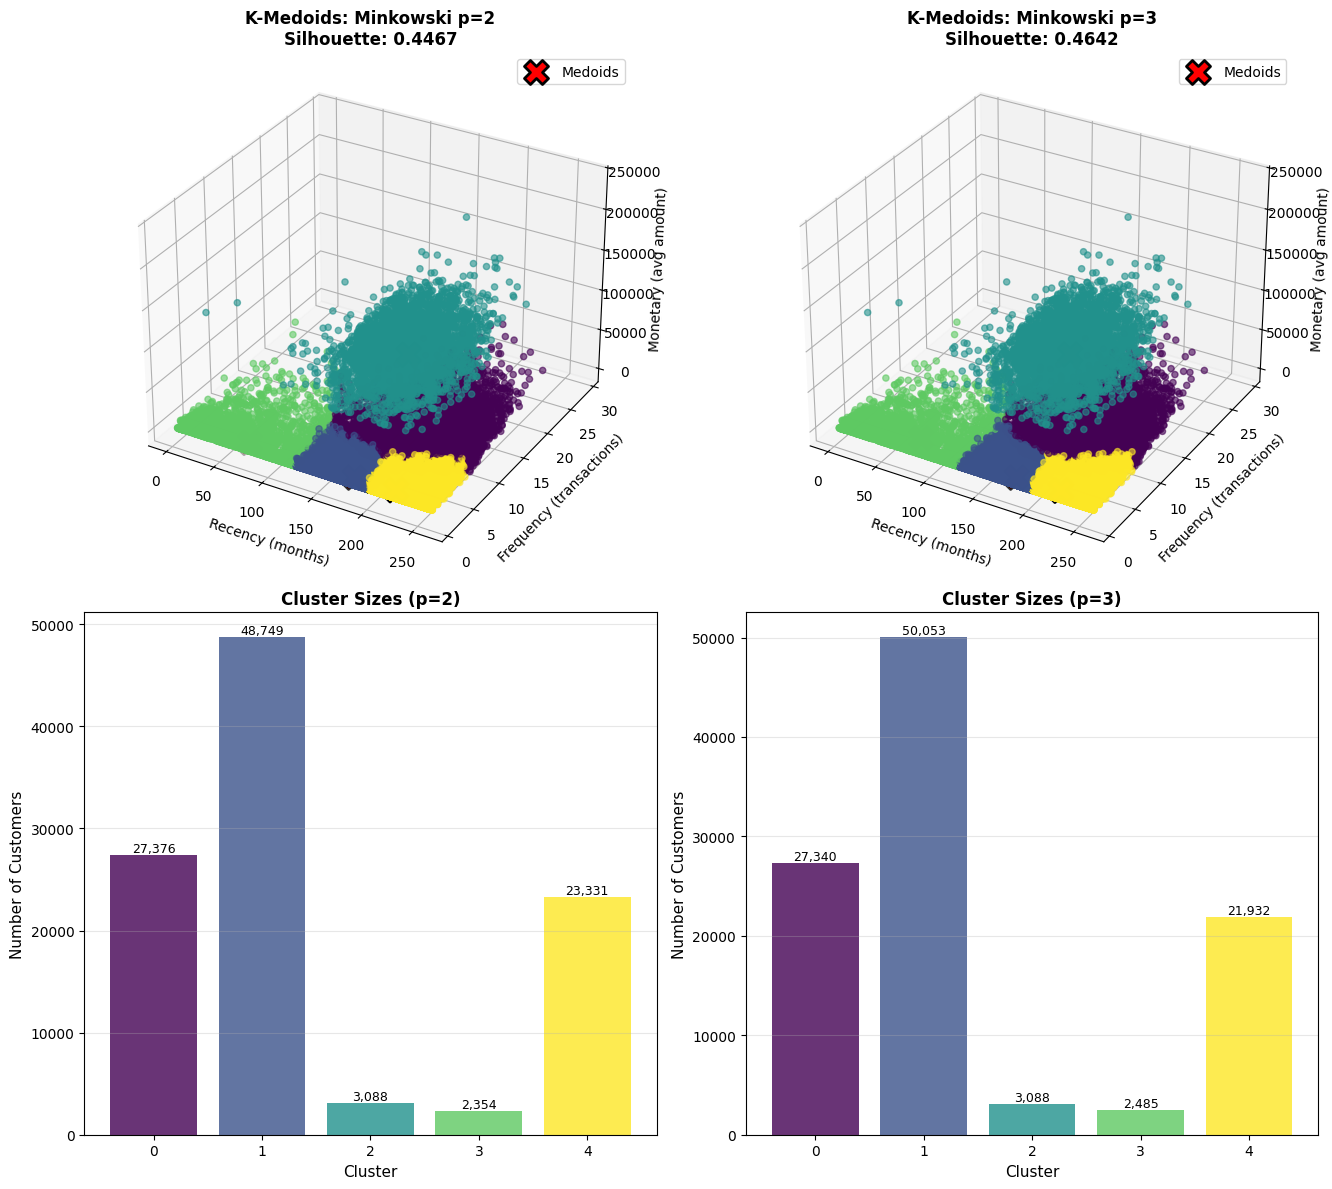

In [ ]:
# ============================================================================
#  VISUALIZE RESULTS
# ============================================================================


fig = plt.figure(figsize=(20, 12))

for idx, (p, result) in enumerate(zip([2, 3, 4], results_comparison)):
    # 3D scatter plot
    ax = fig.add_subplot(2, 3, idx + 1, projection='3d')

    scatter = ax.scatter(
        rfm_df['recency'],
        rfm_df['frequency'],
        rfm_df['monetary'],
        c=result['labels'],
        cmap='viridis',
        alpha=0.6,
        s=20
    )

    # Plot medoids
    centers_original = scaler.inverse_transform(result['centers'])
    ax.scatter(
        centers_original[:, 0],
        centers_original[:, 1],
        centers_original[:, 2],
        c='red',
        marker='X',
        s=300,
        edgecolors='black',
        linewidths=2,
        label='Medoids'
    )

    ax.set_xlabel('Recency (months)', fontsize=10)
    ax.set_ylabel('Frequency (transactions)', fontsize=10)
    ax.set_zlabel('Monetary (avg amount)', fontsize=10)
    ax.set_title(
        f'K-Medoids: Minkowski p={p}\nSilhouette: {result["silhouette"]:.4f}',
        fontsize=12,
        fontweight='bold'
    )
    ax.legend()

    # Cluster size bar chart
    ax_bar = fig.add_subplot(2, 3, idx + 4)
    cluster_sizes = result['cluster_sizes']
    colors = plt.cm.viridis(np.linspace(0, 1, len(cluster_sizes)))

    bars = ax_bar.bar(range(len(cluster_sizes)), cluster_sizes, color=colors, alpha=0.8)
    ax_bar.set_xlabel('Cluster', fontsize=11)
    ax_bar.set_ylabel('Number of Customers', fontsize=11)
    ax_bar.set_title(f'Cluster Sizes (p={p})', fontsize=12, fontweight='bold')
    ax_bar.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax_bar.text(
            bar.get_x() + bar.get_width()/2.,
            height,
            f'{int(height):,}',
            ha='center',
            va='bottom',
            fontsize=9
        )

plt.tight_layout()
# plt.savefig('/content/drive/My Drive/Colab Notebooks/DSC678-Capstone/Banking_Project/kmedoids_minkowski_comparison.png',
#             dpi=300, bbox_inches='tight')
plt.show()

In [ ]:

# ============================================================================
#  LABEL CLUSTERS USING DATA-DRIVEN LOGIC
# ============================================================================
# Use the best p value result
best_result = results_comparison[best_p_idx]
labels = best_result['labels']
centers_original = scaler.inverse_transform(best_result['centers'])

# Add cluster labels to rfm_df
rfm_df['cluster'] = labels

# Calculate comprehensive statistics for each cluster
print("\n" + "="*80)
print("STEP 6A: CALCULATE CLUSTER STATISTICS")
print("="*80)

cluster_analysis = []
for i in range(len(centers_original)):
    cluster_data = rfm_df[rfm_df['cluster'] == i]

    stats = {
        'Cluster': i,
        'Size': len(cluster_data),
        'Percentage': f"{100 * len(cluster_data) / len(rfm_df):.1f}%",
        'Recency_Median': cluster_data['recency'].median(),
        'Recency_Mean': cluster_data['recency'].mean(),
        'Frequency_Median': cluster_data['frequency'].median(),
        'Frequency_Mean': cluster_data['frequency'].mean(),
        'Monetary_Median': cluster_data['monetary'].median(),
        'Monetary_Mean': cluster_data['monetary'].mean(),
    }
    cluster_analysis.append(stats)

# Create analysis DataFrame
cluster_stats_df = pd.DataFrame(cluster_analysis)

print("\nCLUSTER STATISTICS (Medians & Means):")
print(cluster_stats_df.to_string(index=False))


STEP 6A: CALCULATE CLUSTER STATISTICS

CLUSTER STATISTICS (Medians & Means):
 Cluster  Size Percentage  Recency_Median  Recency_Mean  Frequency_Median  Frequency_Mean  Monetary_Median  Monetary_Mean
       0 27340      26.1%      193.233333    196.301414               8.0        8.737089        10197.765   11747.942406
       1 50053      47.7%      176.933333    177.434397               2.0        2.071284          637.970    2110.553155
       2  3088       2.9%      197.233333    197.202731               8.0        8.090674       128101.010  128199.941130
       3  2485       2.4%       74.233333     70.753441               2.0        2.960966         1377.590    4171.197332
       4 21932      20.9%      220.533333    222.709999               2.0        2.348167          617.540    2829.743036


In [ ]:
 #============================================================================
#  COMPARATIVE ANALYSIS - RANK CLUSTERS ON EACH DIMENSION
# ============================================================================


# Create ranking table based on medians
ranking_df = cluster_stats_df[['Cluster', 'Size', 'Percentage',
                                 'Recency_Median', 'Frequency_Median', 'Monetary_Median']].copy()

# Add ranks (lower recency is better, higher frequency/monetary is better)
ranking_df['Recency_Rank'] = ranking_df['Recency_Median'].rank(method='dense', ascending=True)  # Lower is better
ranking_df['Frequency_Rank'] = ranking_df['Frequency_Median'].rank(method='dense', ascending=False)  # Higher is better
ranking_df['Monetary_Rank'] = ranking_df['Monetary_Median'].rank(method='dense', ascending=False)  # Higher is better

print("\nCLUSTER RANKINGS (1=Best on that dimension):")
print(ranking_df.to_string(index=False))

# Calculate overall RFM score (sum of ranks - lower is better overall)
ranking_df['RFM_Score'] = (ranking_df['Recency_Rank'] +
                            ranking_df['Frequency_Rank'] +
                            ranking_df['Monetary_Rank'])




CLUSTER RANKINGS (1=Best on that dimension):
 Cluster  Size Percentage  Recency_Median  Frequency_Median  Monetary_Median  Recency_Rank  Frequency_Rank  Monetary_Rank
       0 27340      26.1%      193.233333               8.0        10197.765           3.0             1.0            2.0
       1 50053      47.7%      176.933333               2.0          637.970           2.0             2.0            4.0
       2  3088       2.9%      197.233333               8.0       128101.010           4.0             1.0            1.0
       3  2485       2.4%       74.233333               2.0         1377.590           1.0             2.0            3.0
       4 21932      20.9%      220.533333               2.0          617.540           5.0             2.0            5.0


In [ ]:
# ============================================================================
#  INTERPRET YOUR SPECIFIC CLUSTERS
# ============================================================================


# Calculate overall benchmarks
overall_recency_median = rfm_df['recency'].median()
overall_frequency_median = rfm_df['frequency'].median()
overall_monetary_median = rfm_df['monetary'].median()
freq_75 = rfm_df['frequency'].quantile(0.75)
mon_75 = rfm_df['monetary'].quantile(0.75)
mon_90 = rfm_df['monetary'].quantile(0.90)
rec_25 = rfm_df['recency'].quantile(0.25)

print(f"\nOverall Dataset Benchmarks:")
print(f"   Recency - Median: {overall_recency_median:.1f} months, Q1 (recent): {rec_25:.1f}")
print(f"   Frequency - Median: {overall_frequency_median:.1f}, Q3 (high): {freq_75:.1f}")
print(f"   Monetary - Median: €{overall_monetary_median:,.2f}, Q3: €{mon_75:,.2f}, Q4: €{mon_90:,.2f}")

# Initialize dictionaries
cluster_names = {}
cluster_strategies = {}

# Define optimal_k for later use
optimal_k = len(centers_original)


Overall Dataset Benchmarks:
   Recency - Median: 185.9 months, Q1 (recent): 174.2
   Frequency - Median: 3.0, Q3 (high): 6.0
   Monetary - Median: €872.03, Q3: €8,728.98, Q4: €16,811.90


In [ ]:
# Analyze each cluster based on ACTUAL characteristics
for i in range(len(centers_original)):
    row = ranking_df[ranking_df['Cluster'] == i].iloc[0]

    r_median = row['Recency_Median']
    f_median = row['Frequency_Median']
    m_median = row['Monetary_Median']
    size = row['Size']
    pct = row['Percentage']

    print(f"\n{'='*80}")
    print(f"CLUSTER {i}")
    print(f"{'='*80}")
    print(f"Size: {size:,} ({pct})")
    print(f"Medians: R={r_median:.1f}, F={f_median:.1f}, M=€{m_median:,.2f}")
    print(f"Ranks: R={int(row['Recency_Rank'])} | F={int(row['Frequency_Rank'])} | M={int(row['Monetary_Rank'])}")

    # Determine characteristics
    is_recent = r_median < overall_recency_median
    is_very_recent = r_median < rec_25
    is_high_freq = f_median >= overall_frequency_median
    is_very_high_freq = f_median >= freq_75
    is_high_monetary = m_median >= overall_monetary_median
    is_very_high_monetary = m_median >= mon_75
    is_ultra_high_monetary = m_median >= mon_90

    print(f"\nCharacteristics:")
    print(f"  Recency: {'VERY RECENT ✓✓' if is_very_recent else 'RECENT ✓' if is_recent else 'NOT RECENT ✗'}")
    print(f"  Frequency: {'VERY HIGH ✓✓' if is_very_high_freq else 'HIGH ✓' if is_high_freq else 'LOW ✗'}")
    print(f"  Monetary: {'ULTRA-HIGH ✓✓✓' if is_ultra_high_monetary else 'VERY HIGH ✓✓' if is_very_high_monetary else 'HIGH ✓' if is_high_monetary else 'LOW ✗'}")

    # DATA-DRIVEN LABELING LOGIC
    # Rule 1: Ultra-high monetary + High frequency = Champions or VIP Champions
    if is_ultra_high_monetary and is_very_high_freq:
        name = "VIP Champions"
        strategy = "PROTECT: White-glove service, dedicated managers"
        rationale = "Ultra-high value (€{:,.0f}) + Very high frequency ({}) = Top tier customers".format(m_median, f_median)

    # Rule 2: Very high frequency + High monetary (but not ultra) = Champions
    elif is_very_high_freq and is_very_high_monetary:
        name = "Champions"
        strategy = "RETAIN: Loyalty programs, prevent churn"
        rationale = "Very high frequency ({}) + High value (€{:,.0f}) = Most loyal segment".format(f_median, m_median)

    # Rule 3: Very recent + Low frequency/monetary = New Joiners
    elif is_very_recent and not is_high_freq:
        name = "New Joiners"
        strategy = "ONBOARD: Welcome campaigns, education"
        rationale = "Very recent ({:.0f} months) but low activity = New customers".format(r_median)

    # Rule 4: Not recent + Low frequency + Low monetary = Hibernating
    elif not is_recent and not is_high_freq and not is_high_monetary:
        name = "Hibernating"
        strategy = "REACTIVATE: Win-back campaigns"
        rationale = "Not recent ({:.0f} months) + Low freq + Low value = Dormant".format(r_median)

    # Rule 5: High frequency but low-medium monetary = Loyal Customers
    elif is_high_freq and is_high_monetary:
        name = "Loyal Customers"
        strategy = "UPSELL: Cross-sell, premium products"
        rationale = "High frequency ({}) + Medium value (€{:,.0f}) = Stable base".format(f_median, m_median)

    # Rule 6: Not recent + Low frequency = Hibernating
    elif not is_recent and not is_high_freq:
        name = "Hibernating"
        strategy = "REACTIVATE: Win-back campaigns"
        rationale = "Not recent ({:.0f} months) + Low frequency = Inactive".format(r_median)

    # Rule 7: Default for edge cases
    else:
        name = "Core Customers"
        strategy = "MAINTAIN: Standard engagement"
        rationale = "Mixed characteristics"

    cluster_names[i] = name
    cluster_strategies[i] = strategy

    print(f"\nASSIGNED LABEL: {name}")
    print(f"RATIONALE: {rationale}")
    print(f"STRATEGY: {strategy}")


CLUSTER 0
Size: 27,340 (26.1%)
Medians: R=193.2, F=8.0, M=€10,197.76
Ranks: R=3 | F=1 | M=2

Characteristics:
  Recency: NOT RECENT ✗
  Frequency: VERY HIGH ✓✓
  Monetary: VERY HIGH ✓✓

ASSIGNED LABEL: Champions
RATIONALE: Very high frequency (8.0) + High value (€10,198) = Most loyal segment
STRATEGY: RETAIN: Loyalty programs, prevent churn

CLUSTER 1
Size: 50,053 (47.7%)
Medians: R=176.9, F=2.0, M=€637.97
Ranks: R=2 | F=2 | M=4

Characteristics:
  Recency: RECENT ✓
  Frequency: LOW ✗
  Monetary: LOW ✗

ASSIGNED LABEL: Core Customers
RATIONALE: Mixed characteristics
STRATEGY: MAINTAIN: Standard engagement

CLUSTER 2
Size: 3,088 (2.9%)
Medians: R=197.2, F=8.0, M=€128,101.01
Ranks: R=4 | F=1 | M=1

Characteristics:
  Recency: NOT RECENT ✗
  Frequency: VERY HIGH ✓✓
  Monetary: ULTRA-HIGH ✓✓✓

ASSIGNED LABEL: VIP Champions
RATIONALE: Ultra-high value (€128,101) + Very high frequency (8.0) = Top tier customers
STRATEGY: PROTECT: White-glove service, dedicated managers

CLUSTER 3
Size: 2,48

In [ ]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("STEP 6D: FINAL CLUSTER SUMMARY")
print("="*80)

# Add labels to dataframe
rfm_df['cluster_name'] = rfm_df['cluster'].map(cluster_names)
rfm_df['cluster_strategy'] = rfm_df['cluster'].map(cluster_strategies)

# Create summary table
summary_table = []
for i in range(optimal_k):
    cluster_data = rfm_df[rfm_df['cluster'] == i]
    summary_table.append({
        'Cluster': i,
        'Name': cluster_names[i],
        'Size': len(cluster_data),
        'Percentage': f"{100 * len(cluster_data) / len(rfm_df):.1f}%",
        'R_Median': f"{cluster_data['recency'].median():.0f}",
        'F_Median': f"{cluster_data['frequency'].median():.0f}",
        'M_Median': f"€{cluster_data['monetary'].median():,.0f}",
        'RFM_Score': f"{ranking_df[ranking_df['Cluster']==i]['RFM_Score'].values[0]:.0f}",
        'Strategy': cluster_strategies[i]
    })

summary_df = pd.DataFrame(summary_table)
print("\n FINAL CLUSTER PROFILES:")
print(summary_df.to_string(index=False))

# Check uniqueness
unique_names = set(cluster_names.values())
print(f"\n All {optimal_k} clusters have unique names!")

print("\n Distribution by Segment:")
for i in range(optimal_k):
    cluster_data = rfm_df[rfm_df['cluster'] == i]
    count = len(cluster_data)
    pct = 100 * count / len(rfm_df)
    print(f"   {cluster_names[i]}: {count:,} customers ({pct:.1f}%)")


STEP 6D: FINAL CLUSTER SUMMARY

 FINAL CLUSTER PROFILES:
 Cluster           Name  Size Percentage R_Median F_Median M_Median RFM_Score                                         Strategy
       0      Champions 27340      26.1%      193        8  €10,198         6          RETAIN: Loyalty programs, prevent churn
       1 Core Customers 50053      47.7%      177        2     €638         8                    MAINTAIN: Standard engagement
       2  VIP Champions  3088       2.9%      197        8 €128,101         6 PROTECT: White-glove service, dedicated managers
       3    New Joiners  2485       2.4%       74        2   €1,378         6            ONBOARD: Welcome campaigns, education
       4    Hibernating 21932      20.9%      221        2     €618        12                   REACTIVATE: Win-back campaigns

 All 5 clusters have unique names!

 Distribution by Segment:
   Champions: 27,340 customers (26.1%)
   Core Customers: 50,053 customers (47.7%)
   VIP Champions: 3,088 customers 

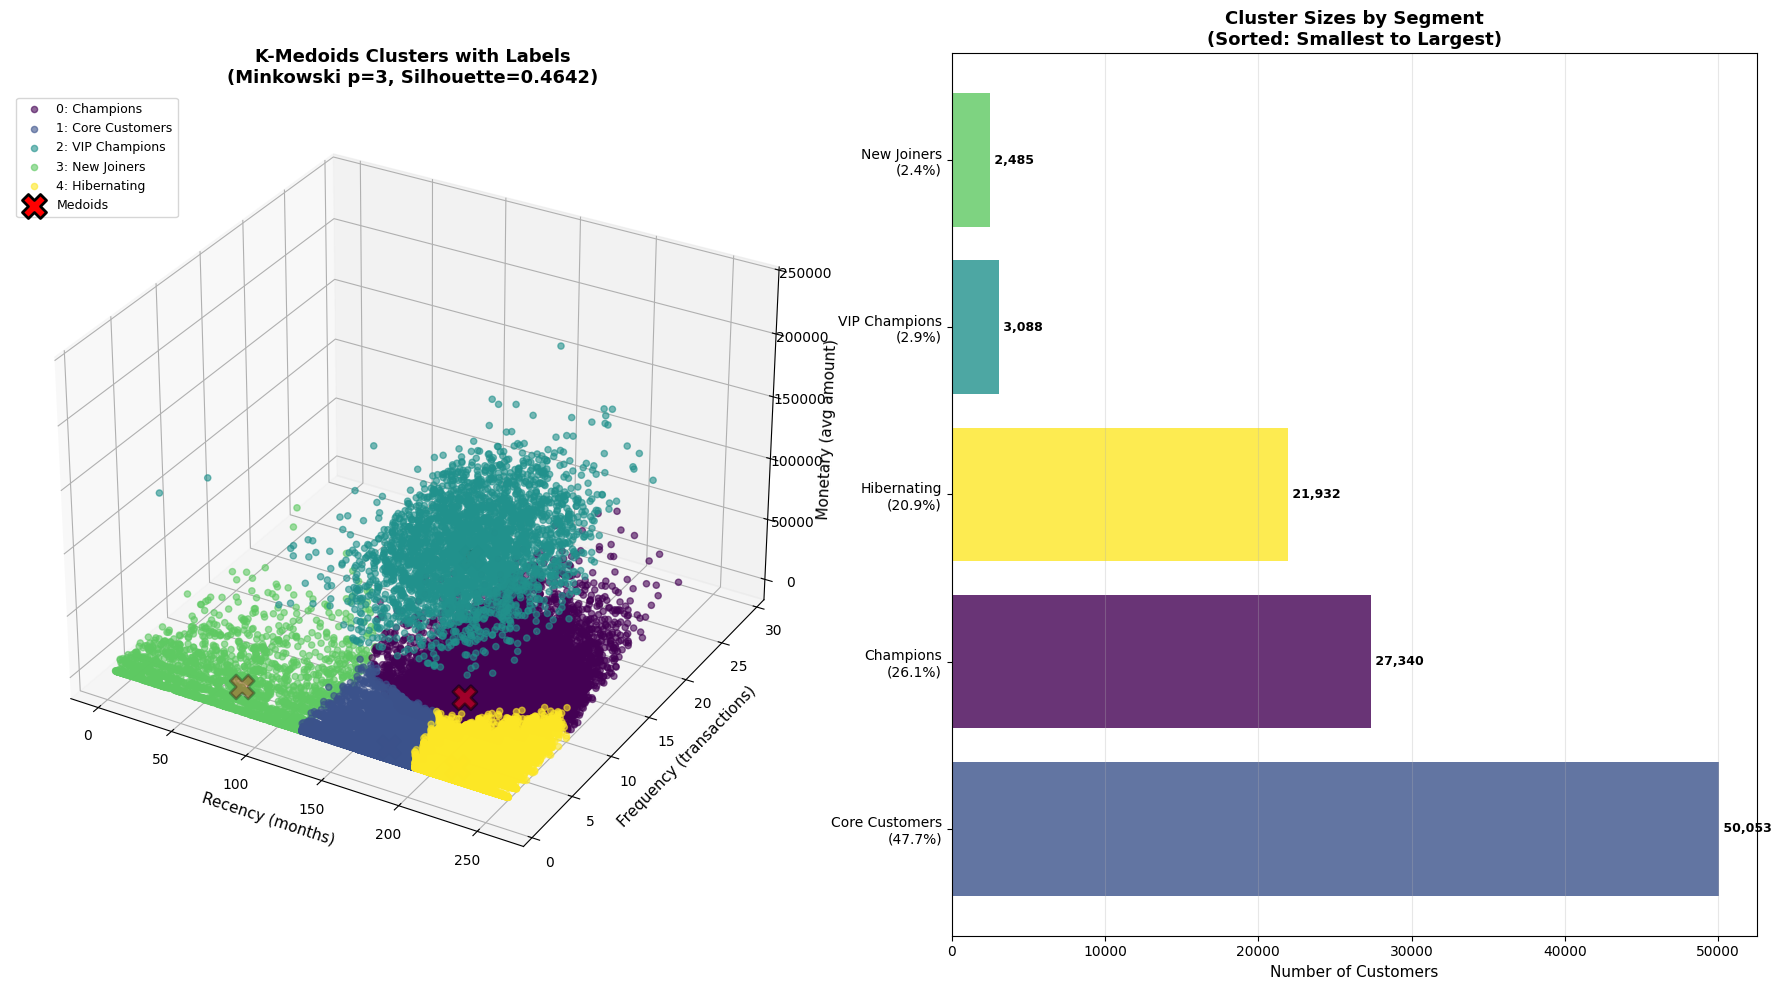

In [ ]:
# ============================================================================
#  VISUALIZE LABELED CLUSTERS
# ============================================================================


# Create visualization with cluster names
fig = plt.figure(figsize=(18, 10))

# 3D scatter plot with named clusters
ax1 = fig.add_subplot(1, 2, 1, projection='3d')

# Create color map for clusters
colors = plt.cm.viridis(np.linspace(0, 1, optimal_k))
for i in range(optimal_k):
    cluster_mask = labels == i
    ax1.scatter(
        rfm_df.loc[cluster_mask, 'recency'],
        rfm_df.loc[cluster_mask, 'frequency'],
        rfm_df.loc[cluster_mask, 'monetary'],
        c=[colors[i]],
        label=f"{i}: {cluster_names[i]}",
        alpha=0.6,
        s=20
    )

# Plot medoids
ax1.scatter(
    centers_original[:, 0],
    centers_original[:, 1],
    centers_original[:, 2],
    c='red',
    marker='X',
    s=300,
    edgecolors='black',
    linewidths=2,
    label='Medoids'
)

ax1.set_xlabel('Recency (months)', fontsize=11)
ax1.set_ylabel('Frequency (transactions)', fontsize=11)
ax1.set_zlabel('Monetary (avg amount)', fontsize=11)
ax1.set_title(
    f'K-Medoids Clusters with Labels\n(Minkowski p={best_p}, Silhouette={best_silhouette:.4f})',
    fontsize=13,
    fontweight='bold'
)
ax1.legend(loc='upper left', fontsize=9)


ax2 = fig.add_subplot(1, 2, 2)

# Create data for sorting
cluster_data_for_plot = []
for i in range(optimal_k):
    cluster_data_for_plot.append({
        'cluster_id': i,
        'size': summary_table[i]['Size'],
        'name': cluster_names[i],
        'percentage': summary_table[i]['Percentage'],
        'color': colors[i]
    })

# Sort by size (ascending - smallest to largest)
cluster_data_for_plot.sort(key=lambda x: x['size'],reverse=True)

# Extract sorted data
sorted_sizes = [item['size'] for item in cluster_data_for_plot]
sorted_labels = [f"{item['name']}\n({item['percentage']})" for item in cluster_data_for_plot]
sorted_colors = [item['color'] for item in cluster_data_for_plot]

# Create horizontal bar chart with sorted data
bars = ax2.barh(range(len(sorted_sizes)), sorted_sizes, color=sorted_colors, alpha=0.8)
ax2.set_yticks(range(len(sorted_sizes)))
ax2.set_yticklabels(sorted_labels, fontsize=10)
ax2.set_xlabel('Number of Customers', fontsize=11)
ax2.set_title('Cluster Sizes by Segment\n(Sorted: Smallest to Largest)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax2.text(
        width,
        bar.get_y() + bar.get_height()/2,
        f' {int(width):,}',
        ha='left',
        va='center',
        fontsize=9,
        fontweight='bold'
    )

plt.tight_layout()
# plt.savefig('/content/drive/My Drive/Colab Notebooks/DSC678-Capstone/Banking_Project/kmedoids_labeled_clusters.png',
#             dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
rfm_df.head()

,customer_id,recency,frequency,monetary,cluster,cluster_name,cluster_strategy
0,15891,10.133333,1.0,341.33,3,New Joiners,"ONBOARD: Welcome campaigns, education"
1,15899,260.100000,6.0,14823.15,4,Hibernating,REACTIVATE: Win-back campaigns
2,15900,260.100000,7.0,2524.94,4,Hibernating,REACTIVATE: Win-back campaigns
3,15902,260.100000,2.0,10218.54,4,Hibernating,REACTIVATE: Win-back campaigns
4,15906,186.000000,13.0,152711.31,2,VIP Champions,"PROTECT: White-glove service, dedicated managers"


In [ ]:
# Mount Google Drive (if not already mounted)
from google.colab import drive
import os

drive.mount('/content/drive')

# Create the directory structure if it doesn't exist
import os

# Define the full path (based on your Drive structure)
save_path = '/content/drive/My Drive/Colab Notebooks/DSC678-Capstone/Banking_Project/RFM/'


# Create directories if they don't exist
os.makedirs(save_path, exist_ok=True)
print(f"✓ Directory created/verified: {save_path}")

# Save the DataFrame
rfm_df.to_parquet(save_path + 'rfm.parquet', index=True)
print(f"✓ File saved successfully to: {save_path}rfm.parquet")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Directory created/verified: /content/drive/My Drive/Colab Notebooks/DSC678-Capstone/Banking_Project/RFM/
✓ File saved successfully to: /content/drive/My Drive/Colab Notebooks/DSC678-Capstone/Banking_Project/RFM/rfm.parquet


In [ ]:
# ============================================================================
# COMBINE CLUSTERS WITH DATAFRAME
# ============================================================================

# Merge cluster information with full customer data
customer_analysis = active_customers.copy()
customer_analysis['cluster'] = labels
customer_analysis['cluster_name'] = customer_analysis['cluster'].map(cluster_names)

# Add RFM scores from clustering
customer_analysis = customer_analysis.merge(
    rfm_df[['customer_id','recency', 'frequency', 'monetary']],
    on='customer_id',
    how='left'
)

customer_analysis.head()

,customer_id,residence_country,gender,age,first_join_date,residence_index,channel_entrance,activity_status,household_gross_income,saving_account,...,norm_diversity,norm_frequency,engagement_score,engagement_category,recency_proxy,cluster,cluster_name,recency,frequency,monetary
0,15891,ES,0,59,2020-07-28,Y,KAT,1,122813.94,0,...,0.066667,0.071429,0.029698,Very Low,10.133333,3,New Joiners,10.133333,1.0,341.33
1,15899,ES,1,57,2000-01-16,Y,KAT,1,130835.64,0,...,0.400000,0.428571,0.271758,Low,260.100000,4,Hibernating,260.100000,6.0,14823.15
2,15900,ES,1,48,2000-01-16,Y,KAT,1,105327.03,0,...,0.266667,0.035294,0.148321,Very Low,260.100000,4,Hibernating,260.100000,7.0,2524.94
3,15902,ES,0,57,2000-01-16,Y,KAT,1,230408.25,0,...,0.133333,0.142857,0.082860,Very Low,260.100000,4,Hibernating,260.100000,2.0,10218.54
4,15906,ES,0,55,2006-02-16,Y,KAT,1,81005.49,0,...,0.533333,0.070169,0.444838,Medium,186.000000,2,VIP Champions,186.000000,13.0,152711.31


In [ ]:
# Mount Google Drive (if not already mounted)
from google.colab import drive
import os

drive.mount('/content/drive')

# Create the directory structure if it doesn't exist
import os

# Define the full path (based on your Drive structure)
save_path = '/content/drive/My Drive/Colab Notebooks/DSC678-Capstone/Banking_Project/RFM/'


# Create directories if they don't exist
os.makedirs(save_path, exist_ok=True)
print(f"✓ Directory created/verified: {save_path}")

# Save the DataFrame
customer_analysis.to_parquet(save_path + 'rfm_clusters.parquet', index=True)
print(f"✓ File saved successfully to: {save_path}rfm_clusters.parquet")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Directory created/verified: /content/drive/My Drive/Colab Notebooks/DSC678-Capstone/Banking_Project/RFM/
✓ File saved successfully to: /content/drive/My Drive/Colab Notebooks/DSC678-Capstone/Banking_Project/RFM/rfm_clusters.parquet
